In [1]:
import os
from datetime import datetime
from dateutil.parser import parse
import time

import numpy as np
import pandas as pd
import scipy.stats as scs
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pprint import pprint
from tqdm import tqdm

from src.nft_analytics import NFTAnalytics
from src.ethereum_api import EthereumAPI

In [2]:
gaa = NFTAnalytics("0xA0F38233688bB578c0a88102A95b846c18bc0bA7")
eth_api = EthereumAPI()
DATA_FOLDER = os.path.join("data", "GreatApeSociety")
RESULT_FOLDER = os.path.join("results", "GreatApeSociety")

2021-09-02 11:12:26,095 - src.ethereum_api - INFO - Connected to Infura endpoint.


# Fetch all GreatApe data from OpenSea

Note that this can fail if OpenSea decides to rate limit. Works best at night when the load on their servers is low.

In [ ]:
asset_data = gaa.fetch_data(max_offset=10000)

# Save list to json file for further use

In [ ]:
gaa.save_json(asset_data, filename=os.path.join(DATA_FOLDER, "data.json"))

# Load json file

In [3]:
asset_data = gaa.load_json(filename=os.path.join(DATA_FOLDER, "data.json"))

In [ ]:
def missing_elements_in_sorted_list(L):
    start, end = L[0], L[-1]
    return sorted(set(range(start, end + 1)).difference(L))

## Scatter plot of listing prices with time

In [ ]:
created_dates = []
listing_prices = []
for asset in asset_data:
    if asset["sell_orders"]:
        created_dates.append(parse(asset["sell_orders"][0]["created_date"]))
        listing_prices.append(float(asset["sell_orders"][0]["base_price"]) / 1e18)
listing_prices = np.array(listing_prices)

In [ ]:
fig, ax = plt.subplots()

dates = matplotlib.dates.date2num(created_dates)
ax.plot_date(dates, listing_prices, 'o', alpha=0.5)
fig.autofmt_xdate()
ax.set_ylim(-0.01, 0.1)
ax.set_ylabel("Listing Price (ETH)")
ax.axhline(0.07, color="tab:orange", linestyle="--", label="Current OpenSea floor price")
ax.set_title("Variation of listing price with time")
ax.legend()

#fig.savefig(os.path.join(RESULT_FOLDER, "listing_price_variation_with_time_near_floor.jpg"), bbox_inches="tight", dpi=600)

In [ ]:
# Cost to cleanup floor
np.sum(listing_prices[listing_prices < 0.1])

## Histogram of listing prices

In [ ]:
upper_limit = 3

fig, ax = plt.subplots()
_, bins, _ = ax.hist(listing_prices, histtype='stepfilled', density=True, bins=100, range=[0, upper_limit], alpha=0.5)

params = scs.lognorm.fit(listing_prices[listing_prices < upper_limit])
x_bins = np.linspace(1e-2, np.max(listing_prices[listing_prices < upper_limit]), len(bins)*100) 
ax.plot(x_bins, scs.lognorm.pdf(x_bins, *params), 'tab:red', linewidth=2, label=f"Lognormal distribution\nMean = {params[2]:.2f} ETH")

ax.set_xlabel("Listing Price (ETH)")
ax.set_ylabel("No. of listings (norm.)")
ax.legend()

ax.set_xscale("log")
#fig.savefig(os.path.join(RESULT_FOLDER, "histogram_listing_price_variation_near_floor.jpg"), bbox_inches="tight", dpi=600)

# Sale price with time

In [12]:
sale_prices = []
timestamps = []

for asset in asset_data:
    if asset["last_sale"]:
        if asset["last_sale"]["event_type"] == "successful":
            timestamps.append(parse(asset["last_sale"]["transaction"]["timestamp"]))
            sale_prices.append(float(asset["last_sale"]["total_price"]) / 1e18)
            
sale_prices = np.array(sale_prices)

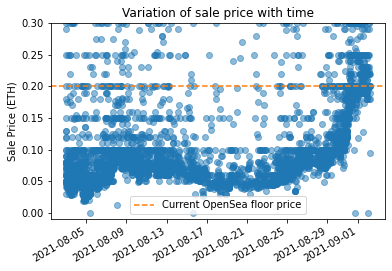

In [15]:
fig, ax = plt.subplots()

dates = matplotlib.dates.date2num(timestamps)
ax.plot_date(dates, sale_prices, 'o', alpha=0.5)
fig.autofmt_xdate()
ax.set_ylim(-0.01, 0.3)
ax.set_ylabel("Sale Price (ETH)")
ax.axhline(0.2, color="tab:orange", linestyle="--", label="Current OpenSea floor price")
ax.set_title("Variation of sale price with time")
ax.legend()

#fig.savefig(os.path.join(RESULT_FOLDER, "sale_price_variation_with_time_near_floor.jpg"), bbox_inches="tight", dpi=600)

# Histogram of sale prices

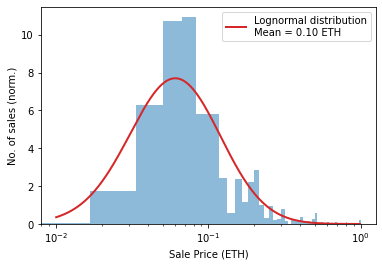

In [16]:
upper_limit = 1

fig, ax = plt.subplots()
_, bins, _ = ax.hist(sale_prices, density=True, bins=60, range=[0, upper_limit], alpha=0.5)

params = scs.lognorm.fit(sale_prices[sale_prices < upper_limit])
x_bins = np.linspace(1e-2, np.max(sale_prices[sale_prices < upper_limit]), len(bins)*100) 
ax.plot(x_bins, scs.lognorm.pdf(x_bins, *params), 'tab:red', linewidth=2, label=f"Lognormal distribution\nMean = {params[2]:.2f} ETH")

ax.set_xlabel("Sale Price (ETH)")
ax.set_ylabel("No. of sales (norm.)")
ax.legend()
ax.set_xscale("log")

#fig.savefig(os.path.join(RESULT_FOLDER, "histogram_sale_price_variation_near_floor.jpg"), bbox_inches="tight", dpi=600)

# Time histogram of number of sales (defined by timestamps within bin)

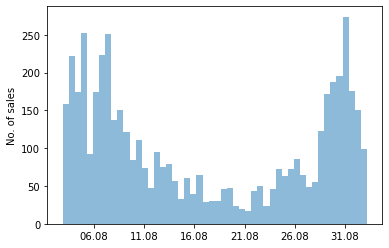

In [18]:
upper_limit = 1

fig, ax = plt.subplots()

unix_timestamps = []

for times in timestamps:
    unix_timestamps.append(times.timestamp())

mpl_data = mdates.epoch2num(unix_timestamps)
_, bins, _ = ax.hist(mpl_data, bins=50, alpha=0.5)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m'))
ax.set_ylabel("No. of sales")

#fig.savefig(os.path.join(RESULT_FOLDER, "histogram_number_of_sales_with_time.jpg"), bbox_inches="tight", dpi=600)

In [27]:
df = pd.DataFrame(columns=["Date", "Sales"])

df["Date"] = sorted(timestamps)
df["Sales"] = np.ones(len(timestamps))
df = df.groupby(df['Date'].dt.date).sum()

In [33]:
df.to_excel(os.path.join(RESULT_FOLDER, "sales_by_day.xlsx"), index=True)

# Time histogram of number of sales over a day (defined by timestamps within bin)

In [ ]:
fig, ax = plt.subplots()

hours = []

for times in timestamps:
    hours.append(times.hour)
    
_, bins, _ = ax.hist(hours, bins=24, alpha=0.5)

ax.set_ylabel("No. of sales")
ax.set_xlabel("Time of day in hours (UTC)")
ax.set_yscale("log")
#fig.savefig(os.path.join(RESULT_FOLDER, "histogram_number_of_sales_with_time_of_day.jpg"), bbox_inches="tight", dpi=600)

# Median price of traits

In [ ]:
traits = {
    "Clothes" : "Hufflepuff",
    "Eyes": "Orange_Glasses",
    "Fur": "Gold_Skin",
    "Background": "Carolina",
    "Mouth": "Laughing_Mouth",
    "Earring": "Green_Red_Earring",
    "Hat": "Fire_Hair"
}

prices = gaa.get_median_prices(asset_data, traits)
print(f"Average price = {np.average(prices):.2f}, Max price = {np.max(prices):.2f}, Min price = {np.min(prices):.2f}")

# Most valuable traits based on listing price

In [ ]:
for trait in traits.keys():
    trait_dict = gaa.get_trait_type_median_price(asset_data, trait)
    val = {k: trait_dict[k] for k in list(trait_dict)[:1]}
    print(f"{trait}: {val}")

# ETH in seller's wallet

In [ ]:
eth_in_wallet_buyer = []
eth_in_wallet_seller = []

for asset in asset_data:
    if asset["last_sale"]:
        if asset["last_sale"]["event_type"] == "successful":
            seller_address = asset["last_sale"]["transaction"]["from_account"]["address"]
            eth_in_wallet_seller.append(eth_api.get_eth_balance(seller_address))
            
            # buyer_address = asset["last_sale"]["transaction"]["to_account"]["address"]
            # eth_in_wallet_buyer.append(get_total_eth_weth_balance(weth_contract, buyer_address))

In [ ]:
gaa.save_json(eth_in_wallet_seller, filename=os.path.join(DATA_FOLDER, "eth_in_wallet_seller.json"))

In [ ]:
eth_in_wallet_seller = gaa.load_json(filename=os.path.join(DATA_FOLDER, "eth_in_wallet_seller.json"))
eth_in_wallet_seller = np.array(eth_in_wallet_seller)

In [ ]:
fig, ax = plt.subplots()

upper_limit = 100

_, bins, _ = ax.hist(eth_in_wallet_seller, density=True, bins=100, alpha=0.5, range=[0, upper_limit], label=f"Median = {np.median(eth_in_wallet_seller):.2f} ETH")

print(f"Under {upper_limit} ETH = {len(eth_in_wallet_seller[eth_in_wallet_seller < upper_limit]) / len(eth_in_wallet_seller) * 100:.2f}%")
print(f"Over {upper_limit} ETH = {len(eth_in_wallet_seller[eth_in_wallet_seller > upper_limit]) / len(eth_in_wallet_seller) * 100:.2f}%")

ax.set_ylabel("No. of wallets")
ax.set_yscale("log")
ax.set_xscale("log")

ax.set_xlabel("ETH in wallet")
ax.legend()

fig.savefig(os.path.join(RESULT_FOLDER, "eth_in_seller_wallet.jpg"), bbox_inches="tight", dpi=600)

# Ape holder addresse

In [4]:
addresses = []

for asset in asset_data:
    addresses.append(asset["owner"]["address"])

In [ ]:
unique_addresses = list(set(addresses))

In [ ]:
len(unique_addresses)

In [5]:
apes_held = {}

for asset in asset_data:
    apes_held[asset["owner"]["address"]] = 0
     
for asset in asset_data:
    apes_held[asset["owner"]["address"]] += 1

In [ ]:
sum(apes_held.values())

10000

In [8]:
df = pd.DataFrame(columns=["Address", "Great_apes"])

for idx, (address, num_apes) in enumerate(apes_held.items()):
    df.loc[idx] = [address, num_apes]

In [9]:
etherscan_links = []
for address in df["Address"]:
    etherscan_links.append(f"https://etherscan.io/address/{address}")
df["Etherscan_link"] = etherscan_links

opensea_links = []
for address in df["Address"]:
    opensea_links.append(f"https://opensea.io/{address}")
df["OpenSea_link"] = opensea_links

In [10]:
df = df.sort_values("Great_apes", ascending=False)

In [11]:
df.to_excel(os.path.join(RESULT_FOLDER, "ape_holders_addresses_balances_and_holdings_method2.xlsx"), index=False)

In [ ]:
df = pd.read_excel(os.path.join(RESULT_FOLDER, "ape_holders_addresses_balances_and_holdings_method2.xlsx"))

In [ ]:
len(df[df["Great_apes"] >= 5]) / (len(df[df["Great_apes"] >= 5]) + len(df[df["Great_apes"] < 5])) * 100

In [ ]:
len(df[df["Great_apes"] >= 5])

# Average ETH/WETH for GreatApe owner (Subsampling)

In [ ]:
events_data = gaa.fetch_events(max_offset=10000)

In [ ]:
len(events_data)

In [ ]:
gaa.save_json(events_data, filename=os.path.join(DATA_FOLDER, "events.json"))

In [ ]:
events_data = gaa.load_json(filename=os.path.join(DATA_FOLDER, "events.json"))

In [ ]:
for event in events_data:
    pprint(event["created_date"])
    break

In [ ]:
bids = []
created_dates = []

for event in events_data:
    if event["bid_amount"]:
        created_dates.append(parse(event["created_date"]))
        bids.append(float(event["bid_amount"]) / 1e18)
bids = np.array(bids)

In [ ]:
fig, ax = plt.subplots()
#ax.set_yscale("log")
dates = matplotlib.dates.date2num(created_dates)
ax.plot_date(dates, bids, 'o', alpha=0.5)
fig.autofmt_xdate()
ax.set_ylabel("Bid Price (ETH)")
ax.axhline(0.06, color="tab:orange", linestyle="--", label="Current OpenSea floor price")
ax.legend()
ax.set_title(f"Variation of bids with time (Bids under floor = {len(bids[bids < 0.06]) / len(bids) * 100:.1f}%)")
fig.savefig(os.path.join(RESULT_FOLDER, "bid_price_variation_with_time.jpg"), bbox_inches="tight", dpi=600)

# Great Apes held by addresses

In [ ]:
ape_contract = eth_api.get_contract("0xA0F38233688bB578c0a88102A95b846c18bc0bA7")

In [ ]:
df = pd.DataFrame(columns=["Address", "ETH_balance", "Great_apes"])

pbar = tqdm(addresses)

for idx, address in enumerate(pbar):
    pbar.set_description(f"{idx}")
    df.loc[idx] = [address, eth_api.get_eth_balance(address), eth_api.get_contract_balance(ape_contract, address)]

In [ ]:
df = df.sort_values("Great_apes", ascending=False)

In [ ]:
etherscan_links = []
for address in df["Address"]:
    etherscan_links.append(f"https://etherscan.io/address/{address}")
df["Etherscan_link"] = etherscan_links

opensea_links = []
for address in df["Address"]:
    opensea_links.append(f"https://opensea.io/{address}")
df["OpenSea_link"] = opensea_links

In [ ]:
df.to_excel(os.path.join(RESULT_FOLDER, "ape_holders_addresses_balances_and_holdings_10k.xlsx"), index=False)

In [ ]:
df = pd.read_excel(os.path.join(RESULT_FOLDER, "ape_holders_addresses_balances_and_holdings_10k.xlsx"))

In [ ]:
df2 = df.drop_duplicates(ignore_index=True)
df2.drop_duplicates("Address")["Great_apes"].sum()

In [ ]:
df["Great_apes"].sum()

In [ ]:
df.drop_duplicates()["Great_apes"].sum()

In [ ]:
df.drop_duplicates("Address")["Great_apes"].sum()

In [ ]:
np.median(df["ETH_balance"][df["Great_apes"] < 5])

In [ ]:
np.median(df["ETH_balance"][df["Great_apes"] > 5])

In [ ]:
len(df["Great_apes"][df["Great_apes"] < 5]) / (len(df["Great_apes"][df["Great_apes"] > 5]) + len(df["Great_apes"][df["Great_apes"] < 5])) * 100

In [ ]:
fig, ax = plt.subplots()

_, bins, _ = ax.hist(df["Great_apes"], bins=30, alpha=0.5, range=[0, 30], label=f"Median = {int(np.median(df['Great_apes']))} Apes")

ax.set_ylabel("No. of wallets")
ax.set_xlabel("Apes in wallet")
ax.legend()
#fig.savefig(os.path.join(RESULT_FOLDER, "eth_weth_holding_of_great_ape_owners.jpg"), bbox_inches="tight", dpi=600)

In [ ]:
df.sort_values("ETH_balance", ascending=False).head(10)

In [ ]:
df.sort_values("Great_apes", ascending=False).head(10)

# Further analysis

In [ ]:
total_traits_count, rarities = gaa.get_total_unique_trait_count_and_rarities(asset_data)

In [ ]:
for asset in asset_data:
    r = get_rarity_score(asset, rarity, total_trait_counts)
    if r == 99:
        print(asset["permalink"])